<a href="https://colab.research.google.com/github/giyeongyoon/lettuce_growth_monitoring/blob/main/lettuce_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load dataset

In [1]:
%%capture
!pip install ultralytics
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Ql1dOvGZp8vqTAnCTntx")
project = rf.workspace("kiyong-kang-qhti3").project("plants-2l8n0")
dataset = project.version(8).download("yolov8")

Import libraries

In [2]:
import os
import shutil
import copy
import yaml
from ultralytics import YOLO
import glob
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline

Create segmentation directory

In [3]:
if not os.path.exists('./Plants-seg/train/images'):
    os.makedirs('./Plants-seg/train/images')

if not os.path.exists('./Plants-seg/train/labels'):
    os.makedirs('./Plants-seg/train/labels')

if not os.path.exists('./Plants-seg/valid/images'):
    os.makedirs('./Plants-seg/valid/images')

if not os.path.exists('./Plants-seg/valid/labels'):
    os.makedirs('./Plants-seg/valid/labels')

In [4]:
t_labels = os.listdir('./Plants-8/train/labels')
v_labels = os.listdir('./Plants-8/valid/labels')

train_src = './Plants-8/train'
val_src = './Plants-8/valid'

train_dir = './Plants-seg/train'
val_dir = './Plants-seg/valid'

Filter segmentation files

In [5]:
def filter_seg_files(src, labels):
    seg_files = []

    for label_name in labels:
        filename = label_name[:-4]
        label_dir = src + '/labels/' + filename + '.txt'
        with open(label_dir, 'r') as f:
            objs = f.readlines()

        for obj in objs:
            ann = obj.split()
            if len(ann) - 1 > 4:
                seg_files.append(filename)

    seg_files = list(set(seg_files))

    return seg_files

In [6]:
seg_t_files = filter_seg_files(train_src, t_labels)
seg_v_files = filter_seg_files(val_src, v_labels)

In [7]:
print('Number of train data: ', len(t_labels))
print('Number of train tip burn data: ', len(seg_t_files))
print('Number of valid data: ', len(v_labels))
print('Number of valid valid data: ', len(seg_v_files))

Number of train data:  1517
Number of train tip burn data:  59
Number of valid data:  133
Number of valid valid data:  0


Move tip burn images/labels for segmentation

In [8]:
def move_seg_files(src, dir, seg_files):
    for filename in seg_files:
        shutil.move(src + '/images/' + filename + '.jpg', dir + '/images/' + filename + '.jpg')
        shutil.move(src + '/labels/' + filename + '.txt', dir + '/labels/' + filename + '.txt')

In [9]:
move_seg_files(train_src, train_dir, seg_t_files)
move_seg_files(val_src, val_dir, seg_v_files)

In [10]:
print('Number of train data: ', len(os.listdir(train_src + '/images')), '/', len(os.listdir(train_src + '/labels')))
print('Number of valid data: ', len(os.listdir(val_src + '/images')), '/', len(os.listdir(val_src + '/labels')))
print('Number of tipburn train images/labels: ', len(os.listdir(train_dir + '/images')), '/', len(os.listdir(train_dir + '/labels')))
print('Number of tipburn valid images/labels: ', len(os.listdir(val_dir + '/images')), '/', len(os.listdir(val_dir + '/labels')))

Number of train data:  1458 / 1458
Number of valid data:  133 / 133
Number of tipburn train images/labels:  59 / 59
Number of tipburn valid images/labels:  0 / 0


In [32]:
x = os.listdir(train_dir + '/images')
x_val = random.sample(x, 6)
x_val = [i[:-4] for i in x_val]

move_seg_files(train_dir, val_dir, x_val)

# for filename in x_val:
#     shutil.move(train_dir + '/images/' + filename + 'jpg', val_dir + '/images/' + filename + 'jpg')
#     shutil.move(train_dir + '/labels/' + filename + 'txt', val_dir + '/labels/' + filename + 'txt')

In [33]:
print('Number of tipburn train images/labels: ', len(os.listdir(train_dir + '/images')), '/', len(os.listdir(train_dir + '/labels')))
print('Number of tipburn valid images/labels: ', len(os.listdir(val_dir + '/images')), '/', len(os.listdir(val_dir + '/labels')))

Number of tipburn train images/labels:  53 / 53
Number of tipburn valid images/labels:  6 / 6


In [40]:
def modify_seg_files(src, labels):
    seg_files = []

    for label_name in labels:
        filename = label_name[:-4]
        label_dir = src + '/labels/' + filename + '.txt'
        img_dir = src + '/images/' + filename + '.jpg'
        with open(label_dir, 'r') as f:
            objs = f.readlines()

        n_obj_tipburn = 0
        objs_tipburn = []
        objs_others = []

        for obj in objs:
            if obj[0] == '0':
                n_obj_tipburn += 1
                objs_tipburn.append(obj)
            else:
                objs_others.append(obj)

        if n_obj_tipburn == len(objs):
            continue
        elif n_obj_tipburn < len(objs) and n_obj_tipburn > 0:
            with open(label_dir, 'w') as f2:
                f2.writelines(objs_tipburn)
        elif n_obj_tipburn == 0:
            os.remove(img_dir)
            os.remove(label_dir)

In [41]:
t_seg_labels = os.listdir('./Plants-seg/train/labels')
v_seg_labels = os.listdir('./Plants-seg/valid/labels')

modify_seg_files(train_dir, t_seg_labels)
modify_seg_files(val_dir, v_seg_labels)

In [42]:
print('Number of tipburn train images/labels: ', len(os.listdir(train_dir + '/images')), '/', len(os.listdir(train_dir + '/labels')))
print('Number of tipburn valid images/labels: ', len(os.listdir(val_dir + '/images')), '/', len(os.listdir(val_dir + '/labels')))

Number of tipburn train images/labels:  51 / 51
Number of tipburn valid images/labels:  5 / 5


Modify config yaml

In [12]:
with open('./Plants-8/data.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    display(config)

{'names': ['Tip_Burn', 'butterhead lettuce', 'romaine lettuce'],
 'nc': 3,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'plants-2l8n0',
  'url': 'https://universe.roboflow.com/kiyong-kang-qhti3/plants-2l8n0/dataset/8',
  'version': 8,
  'workspace': 'kiyong-kang-qhti3'},
 'test': '../test/images',
 'train': 'Plants-8/train/images',
 'val': 'Plants-8/valid/images'}

In [13]:
config['train'] = '/content/Plants-8/train/images'
config['val'] = '/content/Plants-8/valid/images'

In [14]:
with open('./Plants-8/data.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

Create config yaml for segmentation

In [15]:
config_seg = {'train': '/content/Plants-seg/train/images',
              'val': '/content/Plants-seg/valid/images',
              'names': ['Tip_Burn'],
              'nc': 1
             }

In [16]:
with open('./Plants-seg/data.yaml', 'w') as file:
    yaml.dump(config_seg, file, default_flow_style=False)

Explore dataset

In [20]:
import random

img_files = os.listdir('/content/Plants-8/train/images')
filename = random.choice(img_files)
img_file = os.path.join('/content/Plants-8/train/images', filename)
label_file = os.path.join('/content/Plants-8/train/labels', filename[:-3]+'txt')
print(img_file)
print(label_file)

/content/Plants-seg/train/images/Tip_Burn_31_jpg.rf.27cb29e82b1352b4fe0b2a8ab911f52b.tipburn.jpg
/content/Plants-seg/train/labels/Tip_Burn_31_jpg.rf.27cb29e82b1352b4fe0b2a8ab911f52b.tipburn.txt


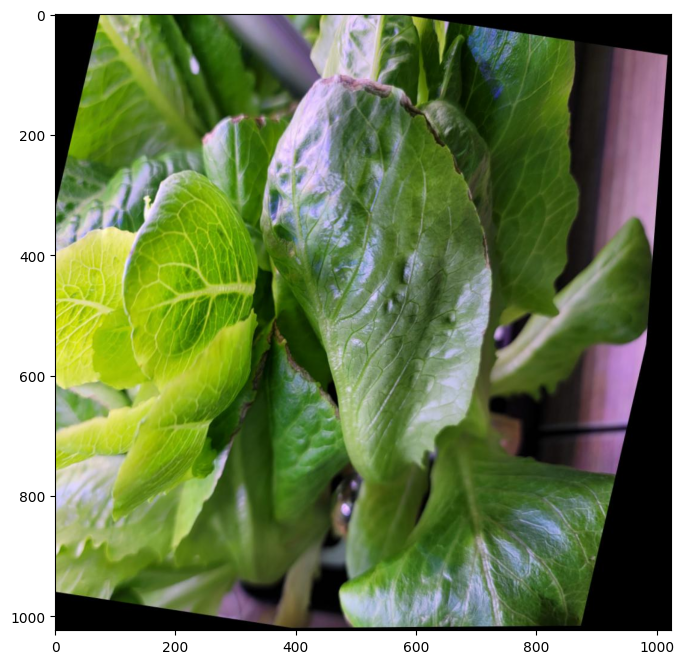

In [21]:
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline

img_files = os.listdir('/content/Plants-seg/train/images')
filename = random.choice(img_files)
img_file = os.path.join('/content/Plants-seg/train/images', filename)
label_file = os.path.join('/content/Plants-seg/train/labels', filename[:-3]+'txt')

img = cv2.imread(img_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)


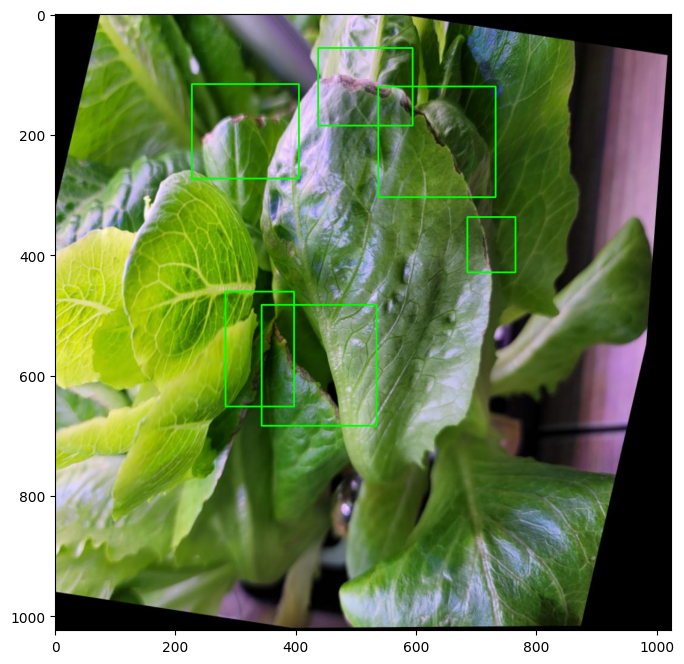

In [33]:
with open(label_file, 'r') as f:
    objs = f.readlines()

boxes = []
for obj in objs:
    box = obj.split()
    box = [float(i) for i in box]
    boxes.append(box)

draw_img = img_rgb.copy()
img_height = img_rgb.shape[0]
img_width = img_rgb.shape[1]

for box in boxes:
    classId = int(box[0])
    cx = img_width * box[1]
    cy = img_height * box[2]
    w = img_width * box[3]
    h = img_height * box[4]
    left = int(cx - w/2)
    top = int(cy - h/2)
    right = int(cx + w/2)
    bottom = int(cy + w/2)

    cv2.rectangle(draw_img, (left, top), (right, bottom), (0, 255, 0), thickness=2)

plt.figure(figsize=(8,8))
plt.imshow(draw_img)

In [11]:
label_files = glob.glob('/content/Plants-seg/train/labels/*.txt')
seg_files = []
seg_ann = []
for label_file in label_files:
    with open(label_file) as f:
        objs = f.readlines()

    for obj in objs:
        ann = obj.split()
        ann = [float(i) for i in ann]
        if len(ann) - 1 > 4:
            seg_files.append(label_file)
            seg_ann.append(ann)

seg_files = list(set(seg_files))
print('# of total seg_files: ', len(label_files))
print('# of seg-files: ', len(seg_files))
print(seg_files)
print('# of seg-ann', len(seg_ann))


# of total seg_files:  59
# of seg-files:  59
['/content/Plants-seg/train/labels/Tip_Burn_70_jpg.rf.48d413af19f31c226114f06ce30fd76a.txt', '/content/Plants-seg/train/labels/Tip_Burn_108_jpg.rf.935d3e742373cbccaea883e5e3b36433.txt', '/content/Plants-seg/train/labels/Tip_Burn_129_jpg.rf.a0cb606c2ea21fb9e33ee8853a72d9d8.txt', '/content/Plants-seg/train/labels/Tip_Burn_32_jpg.rf.92c7ae5fdc386fccc6d2d2c3ae528787.txt', '/content/Plants-seg/train/labels/butterhead_lettuce_95_jpg.rf.f23f6fe23edee07c87c2f1c62d5219c5.txt', '/content/Plants-seg/train/labels/Tip_Burn_110_jpg.rf.b3a62af73b9a2a628b7e4703e681c3a6.txt', '/content/Plants-seg/train/labels/Romaine_120_jpg.rf.a2ed381aaff66b91f1b488ddea118956.txt', '/content/Plants-seg/train/labels/Tip_Burn_32_jpg.rf.96f243d24ca99ef0688298b8dbed9d62.txt', '/content/Plants-seg/train/labels/Tip_Burn_126_jpg.rf.2a5b21206fac8685dca7d24a6c03e8ad.txt', '/content/Plants-seg/train/labels/Tip_Burn_107_jpg.rf.8c1262905b85a6ea121399e6e0d478e6.txt', '/content/Plants-s

In [38]:
seg_file = random.choice(seg_files)
print(seg_file)

/content/Plants-seg/train/labels/Tip_Burn_32_jpg.rf.96f243d24ca99ef0688298b8dbed9d62.tipburn.txt


In [45]:
img_file = seg_file.replace('labels', 'images')
img_file = img_file.replace('txt', 'jpg')
print(img_file)

/content/Plants-seg/train/images/Tip_Burn_32_jpg.rf.96f243d24ca99ef0688298b8dbed9d62.tipburn.jpg


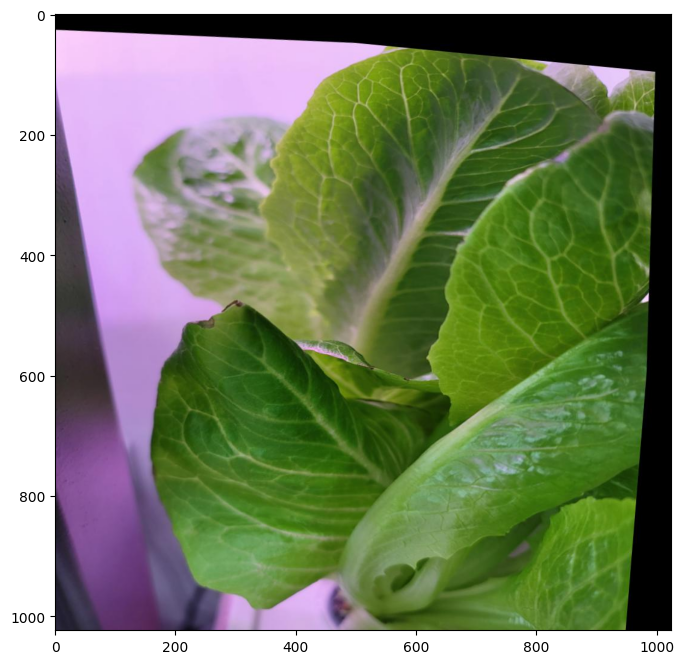

In [46]:
img = cv2.imread(img_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.show()

In [52]:
import numpy as np

with open(seg_file, 'r') as f:
    objs = f.readlines()

boxes = []
for obj in objs:
    box = obj.split()
    box = [float(i) for i in box]
    boxes.append(box)

draw_img = img_rgb.copy()
img_height = img_rgb.shape[0]
img_width = img_rgb.shape[1]

for box in boxes[:1]:
    pts = []
    for i, p in enumerate(box[1:]):
        if i % 2 == 0:
            x = int(p * img_width)
        else:
            y = int(p * img_height)
            pt = [x, y]
            pts.append(pt)

# print(np.array(pts))
pts = np.array(pts)
pts = pts.reshape((-1, 1, 2))
# print(pts.shape)

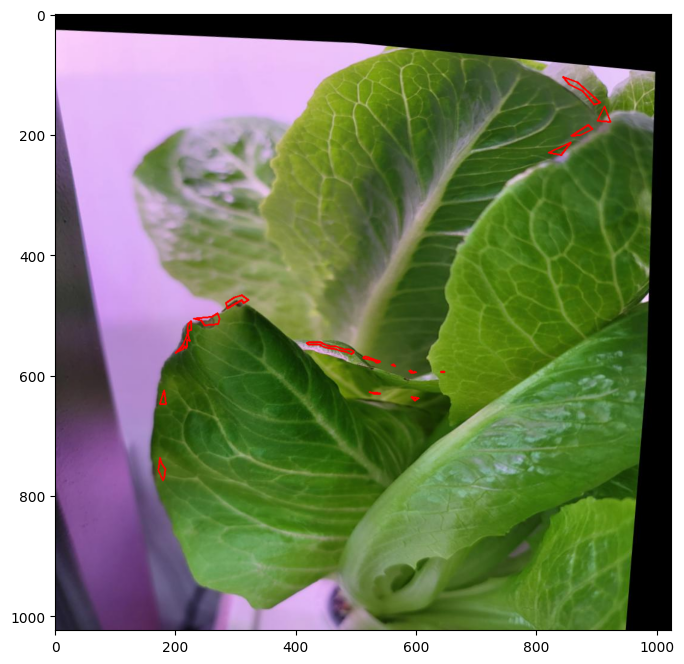

In [54]:
with open(seg_file, 'r') as f:
    objs = f.readlines()

boxes = []
for obj in objs:
    box = obj.split()
    box = [float(i) for i in box]
    boxes.append(box)

draw_img = img_rgb.copy()
img_height = img_rgb.shape[0]
img_width = img_rgb.shape[1]
isClosed = True
color = (255, 0, 0)
thickness = 2

for box in boxes:
    pts = []
    for i, p in enumerate(box[1:]):
        if i % 2 == 0:
            x = int(p * img_width)
        else:
            y = int(p * img_height)
            pt = [x, y]
            pts.append(pt)

    pts = np.array(pts)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(draw_img, [pts], isClosed, color, thickness)

plt.figure(figsize=(8,8))
plt.imshow(draw_img)

Yolov8 - object detection

Load model

In [17]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 101MB/s]


Train model

In [ ]:
results = model.train(data='/content/Plants-8/data.yaml', epochs=300, imgsz=640, exist_ok=True)

Yolov8 - segmentation

In [43]:
model2 = YOLO('yolov8n-seg.pt')

In [ ]:
results2 = model2.train(data='/content/Plants-seg/data.yaml', epochs=300, imgsz=640, batch=2, exist_ok=True)